# Playing w/ Ca imaging tiffs

In [1]:
from ipywidgets import interact, fixed, IntSlider, widgets, Play, IntRangeSlider
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from pathlib import Path
import cv2
import matplotlib.patches as patches

### loading data

In [2]:
filepath = Path('../../data/raw')
assert filepath.exists()
files = list(filepath.glob('*.tif'))
len(files)

2250

In [3]:
data = tifffile.TiffSequence(files).asarray()
data.shape

(2250, 498, 467)

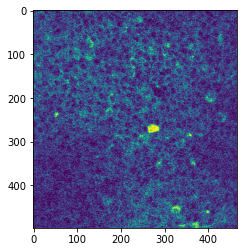

In [4]:
plt.imshow(data[3])

### visualizing individual tifs

In [49]:
@interact(
    idx=widgets.IntText(value=50, description='frame',disabled=False),
    cmap = ["gray", "viridis", "summer"]
)

def show(idx, cmap):
       plt.imshow(data[idx,:,:], cmap = cmap)

interactive(children=(IntText(value=50, description='frame'), Dropdown(description='cmap', options=('gray', 'v…

### video

In [52]:
@interact( 
    idx=widgets.Play(value=0, min=0, max=data.shape[0]-1, step=1, description="Press play",disabled=False),
    cmap = ["gray", "viridis", "summer"]
)

def show(idx, cmap):
       plt.imshow(data[idx,:,:], cmap = cmap)

interactive(children=(Play(value=0, description='Press play', max=2249), Dropdown(description='cmap', options=…

### video w/ cv2

In [12]:
window = cv2.namedWindow('img', cv2.WINDOW_NORMAL)

In [17]:
@interact(
    idx=Play(value=0, min=0, max=len(data) - 1, step=1, interval=50), 
    clim=IntRangeSlider(value=[0, data.max()], min=0, max=data.max()),
    x=IntRangeSlider(value=[0, data.shape[2] - 1], min=0, max=data.shape[2] - 1),
    y=IntRangeSlider(value=[0, data.shape[1] - 1], min=0, max=data.shape[1] - 1),
)
def show_frame(idx, clim, x, y):
    cmin, cmax = clim
    width, height = 10, 10
    frame = data[idx, y[0]:y[1], x[0]:x[1]]
    clipped_frame = np.clip(frame, a_min=cmin, a_max=cmax)
    clipped_frame = (clipped_frame - cmin) / clipped_frame.max()
    cv2.imshow("img", (clipped_frame * 255).astype(np.uint8))
    cv2.waitKey(1)

interactive(children=(Play(value=0, description='idx', interval=50, max=2249), IntRangeSlider(value=(0, 8192),…

In [18]:
cv2.destroyWindow("img")

### adjust contrast

In [54]:
@interact(
    frames=IntSlider(value=0, min=0, max=data.shape[0]-1),
    min=IntSlider(value=np.mean(data), min=0, max=np.amax(data)),
    max=IntSlider(value=np.mean(data), min=0, max=np.amax(data))
)

def plotter(frames, min, max):
    plt.imshow(data[frames], vmin=min, vmax=max)

interactive(children=(IntSlider(value=0, description='frames', max=2249), IntSlider(value=1564, description='m…

### y over time

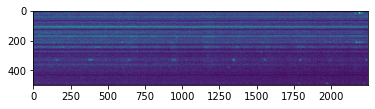

In [42]:
def plot_stack_time(y):
    plt.imshow(data[:,:,y].T)
#plot_stack_time(3)

In [56]:
@interact(
    y=IntSlider(value = 0, min = 0, max = data.shape[2]-1)
)

def plot_stack_time(y):
    plt.imshow(data[:,:,y].T)

interactive(children=(IntSlider(value=0, description='y', max=466), Output()), _dom_classes=('widget-interact'…

### line plots

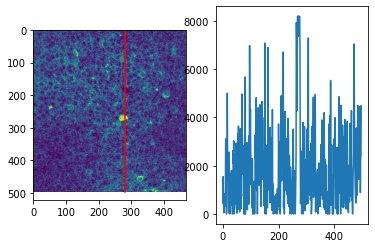

In [71]:
def plotting_line(frame, y, data):
    plt.subplot(1,2,1)
    plt.imshow(data[frame, :, :])
    plt.plot([y, y],[0,data.shape[1]], "r")
    plt.subplot(1,2,2)
    plt.plot(data[frame,:,y])
plotting_2(5,280,data)

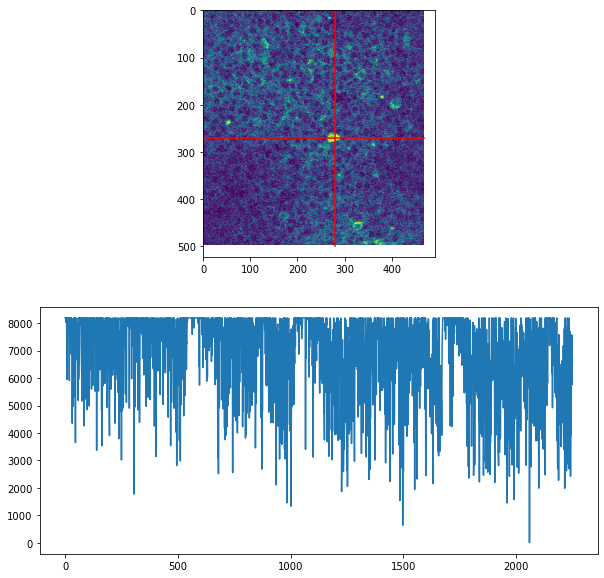

In [120]:
def plotting_fluorescence(horizontal, vertical, data, frame):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.imshow(data[frame, :, :])
    plt.plot([vertical, vertical],[0,data.shape[1]], "r")
    plt.plot([0, data.shape[2]],[horizontal, horizontal], "r")
    plt.subplot(2,1,2)
    plt.plot(data[:,horizontal,vertical])

plotting_3(270,280,data,5)

### ROIs

In [128]:
@interact(
    idx=Play(value=0, min=0, max=len(data) - 1, step=1, interval=50), 
    clim=IntRangeSlider(value=[0, data.max()], min=0, max=data.max()),
    x=IntSlider(value=20, min=0, max=data.shape[2] - 11),
    y=IntSlider(value=20, min=0, max=data.shape[1] - 11),
)
def show_frame(idx, clim, x, y):
    cmin, cmax = clim
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.imshow(data[idx], vmin=cmin, vmax=cmax);
    width, height = 20, 20
    rect = patches.Rectangle((x, y), width, height, facecolor='none', linewidth=1, edgecolor='r')
    ax1.add_patch(rect)
    roi = data[:, y-height//2 : y+height//2, x-width//2 : x+width//2]
    ax2.plot(roi.mean(axis=1).mean(axis=1))
    ax2.vlines([idx], *ax2.get_ylim(), color='red', linewidth=1, linestyle='dotted')

interactive(children=(Play(value=0, description='idx', interval=50, max=2249), IntRangeSlider(value=(0, 8192),…